# Exploration of Raw Meshes

This notebook represents the first step in the exploratory stage. In here, we first analyze the raw 3D meshes at hand.

In [24]:
import os
import random

import pyvista as pv
import vtk
from vtk.util.numpy_support import vtk_to_numpy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dotenv import load_dotenv

load_dotenv()

True

In [25]:
RAW_MESHES_DIR = os.path.join(os.getenv('DATA_DIR_PATH'), 'raw')

First we look at the raw meshes.

In [26]:
stl_files = [file for file in os.listdir(RAW_MESHES_DIR) if file.endswith(".stl")]
len(stl_files)

207

## Taking a look at the meshes

Context leak detected, msgtracer returned -1


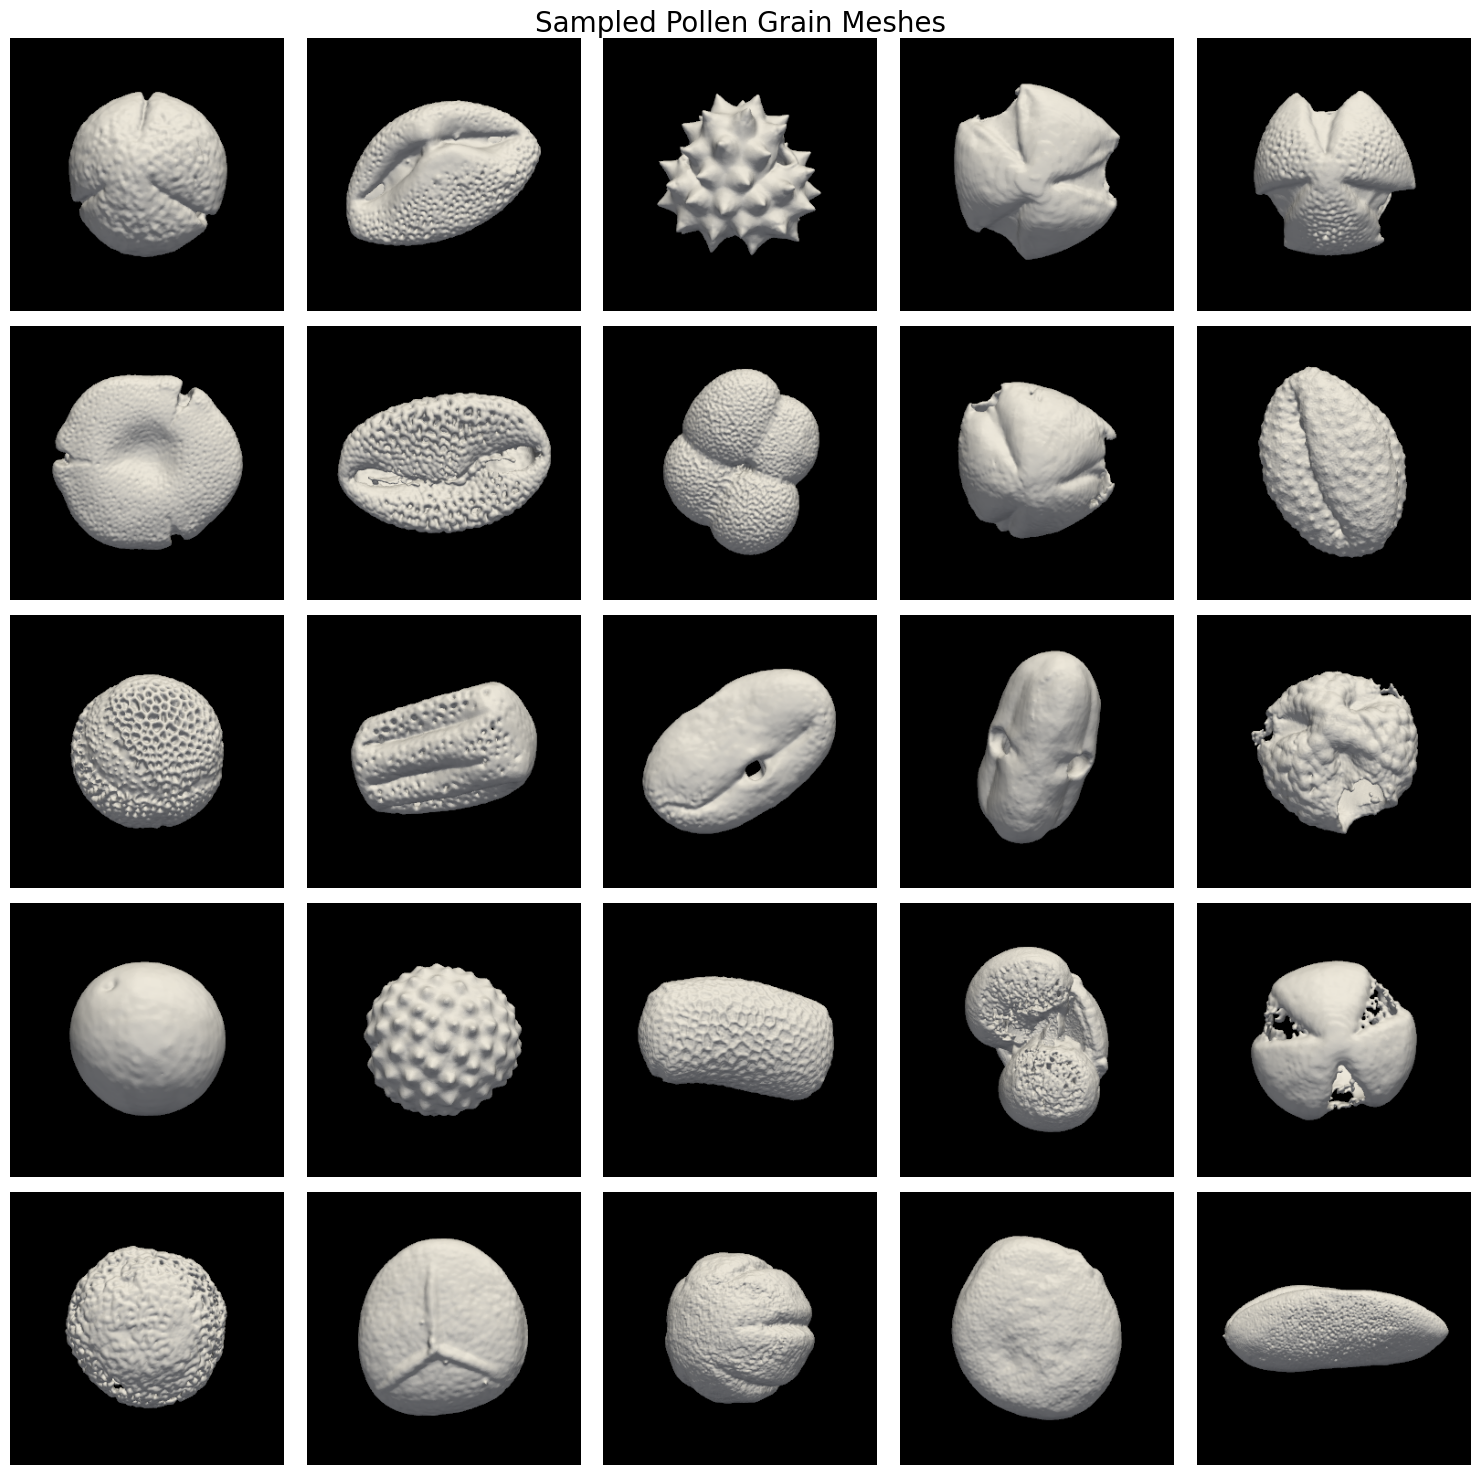

In [27]:
sample_size = 25
sampled_files = random.sample(stl_files, sample_size) if len(stl_files) >= sample_size else stl_files

def get_mesh_screenshot(file_path, width=300, height=300):
    """
    Load a mesh and return a screenshot of it using PyVista in offscreen mode.
    
    Parameters:
        file_path (str): Path to the STL file.
        width (int): Width of the output image.
        height (int): Height of the output image.
        
    Returns:
        np.ndarray or None: The screenshot image as a numpy array, or None if the mesh is empty.
    """
    mesh = pv.read(file_path)
    
    if mesh.n_points == 0:
        print(f"Warning: Mesh at {file_path} is empty. Skipping.")
        return None
    
    plotter = pv.Plotter(off_screen=True, window_size=(width, height))
    plotter.add_mesh(mesh, color="white")
    
    plotter.camera_position = 'xy'
    plotter.background_color = 'black'
    
    img = plotter.screenshot(transparent_background=False)
    plotter.close()
    return img

screenshots = []
for file in sampled_files:
    file_path = os.path.join(RAW_MESHES_DIR, file)
    img = get_mesh_screenshot(file_path)
    if img is not None:
        screenshots.append(img)

if len(screenshots) < 25:
    print(f"Only {len(screenshots)} valid meshes found. Adjusting grid layout accordingly.")
    n_rows = n_cols = int(len(screenshots) ** 0.5) or 1
else:
    n_rows, n_cols = 5, 5

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(screenshots):
        ax.imshow(screenshots[i])
    ax.axis("off")

plt.suptitle("Sampled Pollen Grain Meshes", fontsize=20)
plt.tight_layout()
plt.show()


In [28]:
def load_mesh(file_path):
    """
    Load an STL file and return a PyVista mesh object.
    
    Parameters:
        file_path (str): Path to the STL file.
    
    Returns:
        pv.PolyData: The loaded mesh.
    """
    mesh = pv.read(file_path)
    return mesh

def visualize_mesh(mesh, notebook=True):
    """
    Visualize the provided PyVista mesh.
    
    Parameters:
        mesh (pv.PolyData): The mesh to visualize.
        notebook (bool): Whether to render in a Jupyter notebook environment.
    """
    mesh.plot(notebook=notebook)


if stl_files:
    first_file_path = os.path.join(RAW_MESHES_DIR, stl_files[206])
    mesh_data = load_mesh(first_file_path)
    
    visualize_mesh(mesh_data, notebook=True)
else:
    print("No STL files found in the specified folder.")

Widget(value='<iframe src="http://localhost:58277/index.html?ui=P_0x324725a10_6&reconnect=auto" class="pyvista…

## Mesh Properties
In this section, the following metrics get calculated:
- `n_vertices`: The total number of distinct vertices (points) in the mesh. A higher or lower number of vertices can indicate differences in mesh resolution or detail. This metric helps assess if all meshes have a consistent level of detail.
- `n_faces`: The total number of faces (or cells) in the mesh. In triangulated meshes, each face is a triangle. Similar to vertices, the number of faces informs us about the complexity of the mesh.
- `avg_edge_length`: The average length of all edges in the mesh. Edges are computed from the triangular faces by measuring the distance between pairs of vertices. This metric gives insight into the scale and resolution of the mesh.
- `std_edge_length`: The standard deviation of all the edge lengths in the mesh. It indicates the variability in edge lengths across the mesh. A high standard deviation could for example occur in highly irregular mesh topologies.
- `avg_normal_magnitude`: The average magnitude (or norm) of the point normals if they are available in the mesh. Normals are vectors perpendicular to the mesh surface at each vertex. Ideally, normals are unit vectors. Deviations from a magnitude of 1 could indicate issues in the mesh generation process or errors in the data.

In [29]:
import os
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
from tqdm import tqdm

def compute_mesh_properties(mesh):
    """
    Compute key properties of a mesh using vectorized operations.
    
    Assumes that the mesh is triangulated.
    
    Returns a dictionary with:
      - n_vertices: number of vertices in the mesh.
      - n_faces: number of faces (using n_cells).
      - avg_edge_length: mean length of all edges.
      - std_edge_length: standard deviation of the edge lengths.
      - avg_normal_magnitude: average magnitude of point normals (if available).
    """
    n_vertices = mesh.n_points
    n_faces = mesh.n_cells  # Using n_cells instead of deprecated n_faces

    pts = mesh.points

    try:
        faces = mesh.faces.reshape((-1, 4))[:, 1:4]
    except Exception as e:
        print("Error reshaping faces. Mesh may not be triangulated.")
        return None

    face_pts = pts[faces]

    edge1 = face_pts[:, 1] - face_pts[:, 0]
    edge2 = face_pts[:, 2] - face_pts[:, 1]
    edge3 = face_pts[:, 0] - face_pts[:, 2]

    lengths1 = np.linalg.norm(edge1, axis=1)
    lengths2 = np.linalg.norm(edge2, axis=1)
    lengths3 = np.linalg.norm(edge3, axis=1)

    all_lengths = np.concatenate([lengths1, lengths2, lengths3])
    avg_edge_length = np.mean(all_lengths)
    std_edge_length = np.std(all_lengths)

    if hasattr(mesh, 'point_normals') and mesh.point_normals is not None:
        normals = mesh.point_normals
        avg_normal_magnitude = np.mean(np.linalg.norm(normals, axis=1))
    else:
        avg_normal_magnitude = None

    return {
        'n_vertices': n_vertices,
        'n_faces': n_faces,
        'avg_edge_length': avg_edge_length,
        'std_edge_length': std_edge_length,
        'avg_normal_magnitude': avg_normal_magnitude
    }

def process_file(file_path):
    """
    Helper function to process a single file. Returns mesh properties.
    """
    try:
        mesh = pv.read(file_path)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None
    if mesh.n_points == 0:
        print(f"Skipping empty mesh: {file_path}")
        return None
    props = compute_mesh_properties(mesh)
    return props

def flag_outliers(values):
    """
    Identify outliers based on the IQR method and sort them by how much they deviate from the threshold.
    
    For each value outside the acceptable range, the deviation is measured as:
      - lower deviation: lower_bound - value, if the value is below lower_bound.
      - upper deviation: value - upper_bound, if the value is above upper_bound.
    
    Returns a list of tuples (index, deviation) sorted in descending order of deviation.
    """
    values = np.array(values)
    Q1 = np.percentile(values, 25)
    Q3 = np.percentile(values, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = []
    for i, v in enumerate(values):
        if v < lower_bound:
            deviation = lower_bound - v
            outliers.append((i, deviation))
        elif v > upper_bound:
            deviation = v - upper_bound
            outliers.append((i, deviation))
    # Sort outliers by deviation (largest deviation first)
    outliers_sorted = sorted(outliers, key=lambda x: x[1], reverse=True)
    return outliers_sorted

def analyze_dataset_properties(raw_meshes_dir):
    """
    Process all STL files in the specified directory in parallel using Joblib,
    compute mesh properties, print a summary of the mean and standard deviation
    for each property, and plot each metric on its own subplot with annotated bars.
    Returns the outlier indices for further inspection.
    """
    stl_files = [file for file in os.listdir(raw_meshes_dir) if file.endswith(".stl")]
    file_paths = [os.path.join(raw_meshes_dir, file) for file in stl_files]

    results = Parallel(n_jobs=-1)(
        delayed(process_file)(fp) for fp in tqdm(file_paths, desc="Processing meshes")
    )
    results = [r for r in results if r is not None]
    
    if not results:
        print("No valid meshes processed.")
        return

    # Collect each metric into separate lists
    vertices_list = [r['n_vertices'] for r in results]
    faces_list = [r['n_faces'] for r in results]
    edge_length_list = [r['avg_edge_length'] for r in results]
    edge_length_std_list = [r['std_edge_length'] for r in results]
    normal_mag_list = [r['avg_normal_magnitude'] for r in results if r['avg_normal_magnitude'] is not None]

    summary = {
        'n_vertices': (np.mean(vertices_list), np.std(vertices_list)),
        'n_faces': (np.mean(faces_list), np.std(faces_list)),
        'avg_edge_length': (np.mean(edge_length_list), np.std(edge_length_list)),
        'edge_length_std': (np.mean(edge_length_std_list), np.std(edge_length_std_list))
    }
    if normal_mag_list:
        summary['avg_normal_magnitude'] = (np.mean(normal_mag_list), np.std(normal_mag_list))
    
    print("\n--- Dataset Mesh Properties Summary (mean ± std) ---")
    for key, (mean_val, std_val) in summary.items():
        print(f" - {key}: {mean_val:.2f} ± {std_val:.2f}")
    
    # Compute outlier indices for each property (do not print them)
    outlier_indices = {}
    properties = {
        'n_vertices': vertices_list,
        'n_faces': faces_list,
        'avg_edge_length': edge_length_list,
        'edge_length_std': edge_length_std_list
    }
    if normal_mag_list:
        properties['avg_normal_magnitude'] = normal_mag_list

    for key, values in properties.items():
        sorted_outliers = flag_outliers(values)
        outlier_indices[key] = sorted_outliers
    
    return outlier_indices

outliers = analyze_dataset_properties(RAW_MESHES_DIR)


Processing meshes:  19%|█▉        | 40/207 [00:06<00:21,  7.83it/s]/Users/nils/Documents/Classes/bat/sequoia/.venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Processing meshes: 100%|██████████| 207/207 [00:27<00:00,  7.40it/s]



--- Dataset Mesh Properties Summary (mean ± std) ---
 - n_vertices: 255076.74 ± 180030.10
 - n_faces: 510211.17 ± 360098.31
 - avg_edge_length: 0.21 ± 0.10
 - edge_length_std: 0.09 ± 0.03
 - avg_normal_magnitude: 1.00 ± 0.00


In [30]:
outliers['n_vertices']

[(41, np.float64(448294.0)),
 (140, np.float64(317827.0)),
 (198, np.float64(139872.0)),
 (136, np.float64(110124.0)),
 (190, np.float64(105405.0)),
 (54, np.float64(96355.0)),
 (182, np.float64(83609.0)),
 (184, np.float64(53618.0)),
 (60, np.float64(51505.0)),
 (134, np.float64(44168.0)),
 (79, np.float64(3871.0))]

In [31]:
def plot_top_outliers(metric_outliers, top_n=5, offset_distance=200.0, raw_meshes_dir=RAW_MESHES_DIR):
    """
    Plot the top_n outlier meshes for a given metric in a single PyVista window.
    
    Parameters:
        metric_outliers (list of tuples): Each tuple is (index, deviation), sorted by deviation in descending order.
                                          For example, outliers['n_vertices'].
        top_n (int): Number of top outlier meshes to plot.
        offset_distance (float): The distance to offset each successive mesh along the x-axis to avoid overlap.
        raw_meshes_dir (str): The directory containing your STL files.
    """
    stl_files = [file for file in os.listdir(raw_meshes_dir) if file.endswith(".stl")]
    
    # Get the top_n outliers (if there are fewer, use all available)
    top_outliers = metric_outliers[:top_n]

    # print out which outliers are being plotted
    print(f"--- Plotting top {len(top_outliers)} outliers ---")
    for i, (idx, deviation) in enumerate(top_outliers):
        print(f" - {idx}: {stl_files[idx]} (deviation: {deviation:.2f})")
    
    # Create a PyVista Plotter instance
    plotter = pv.Plotter()
    
    # Loop over the top outliers, load and offset each mesh, then add it to the plotter.
    for i, (idx, deviation) in enumerate(top_outliers):
        file_path = os.path.join(raw_meshes_dir, stl_files[idx])
        try:
            mesh = pv.read(file_path)
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
            continue
        
        # Calculate an offset vector along the x-axis to avoid overlap
        offset = np.array([i * offset_distance, 0, 0])
        mesh.translate(offset, inplace=True)
        
        # Add the mesh to the plotter
        plotter.add_mesh(mesh, color='white', opacity=0.8)
    
    plotter.show()

plot_top_outliers(outliers['n_vertices'], top_n=5)

--- Plotting top 5 outliers ---
 - 41: 17846_Polypodium%20vulgare%20-%20Common%20fern_NIH3D.stl (deviation: 448294.00)
 - 140: 17826_Passiflora%20caerulea%20-%20Blue%20passion%20flower_NIH3D.stl (deviation: 317827.00)
 - 198: 20939_tsuga_heterophylla_NIH3D.stl (deviation: 139872.00)
 - 136: 20611_cardamine_pratensis_NIH3D.stl (deviation: 110124.00)
 - 190: 17842_Corylus%20avellana%20-%20Common%20hazel_NIH3D.stl (deviation: 105405.00)


Widget(value='<iframe src="http://localhost:58277/index.html?ui=P_0x30a0c4710_7&reconnect=auto" class="pyvista…

## Detecting Duplicates

In [32]:
import os
import numpy as np
import pyvista as pv
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler

def compute_mesh_properties(mesh):
    """
    Compute key properties of a mesh using vectorized operations.
    
    Assumes that the mesh is triangulated.
    
    Returns a dictionary with:
      - n_vertices: number of vertices in the mesh.
      - n_faces: number of faces (using n_cells).
      - avg_edge_length: mean length of all edges.
      - std_edge_length: standard deviation of the edge lengths.
      - avg_normal_magnitude: average magnitude of point normals (if available).
    """
    n_vertices = mesh.n_points
    n_faces = mesh.n_cells  # Using n_cells instead of deprecated n_faces

    pts = mesh.points

    try:
        faces = mesh.faces.reshape((-1, 4))[:, 1:4]
    except Exception as e:
        print("Error reshaping faces. Mesh may not be triangulated.")
        return None

    face_pts = pts[faces]

    edge1 = face_pts[:, 1] - face_pts[:, 0]
    edge2 = face_pts[:, 2] - face_pts[:, 1]
    edge3 = face_pts[:, 0] - face_pts[:, 2]

    lengths1 = np.linalg.norm(edge1, axis=1)
    lengths2 = np.linalg.norm(edge2, axis=1)
    lengths3 = np.linalg.norm(edge3, axis=1)

    all_lengths = np.concatenate([lengths1, lengths2, lengths3])
    avg_edge_length = np.mean(all_lengths)
    std_edge_length = np.std(all_lengths)

    if hasattr(mesh, 'point_normals') and mesh.point_normals is not None:
        normals = mesh.point_normals
        avg_normal_magnitude = np.mean(np.linalg.norm(normals, axis=1))
    else:
        avg_normal_magnitude = None

    return {
        'n_vertices': n_vertices,
        'n_faces': n_faces,
        'avg_edge_length': avg_edge_length,
        'std_edge_length': std_edge_length,
        'avg_normal_magnitude': avg_normal_magnitude
    }

def process_file(file_path):
    """
    Helper function to process a single file. Returns mesh properties.
    """
    try:
        mesh = pv.read(file_path)
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None
    if mesh.n_points == 0:
        print(f"Skipping empty mesh: {file_path}")
        return None
    props = compute_mesh_properties(mesh)
    return props

def detect_duplicate_meshes(raw_meshes_dir, threshold=0.5):
    """
    Detect duplicate (or very similar) meshes based on their geometric properties.
    
    This function computes a feature vector for each mesh using the following properties:
      - n_vertices
      - n_faces
      - avg_edge_length
      - std_edge_length
    
    The feature vectors are normalized, and pairwise Euclidean distances are computed.
    Meshes whose feature distance is below the threshold are flagged as potential duplicates.
    
    Parameters:
        raw_meshes_dir (str): Directory containing STL files.
        threshold (float): Distance threshold in the normalized feature space below which two meshes
                           are considered duplicates.
    
    Returns:
        duplicates (dict): A dictionary where each key is a filename and its value is a list of filenames
                           considered as duplicates (i.e. very similar) to that file.
    """
    # Gather all STL file names
    stl_files = [file for file in os.listdir(raw_meshes_dir) if file.endswith(".stl")]
    file_paths = [os.path.join(raw_meshes_dir, file) for file in stl_files]
    
    # Process all files in parallel
    results = Parallel(n_jobs=-1)(
        delayed(process_file)(fp) for fp in tqdm(file_paths, desc="Processing meshes for duplicates")
    )
    # Only keep valid results
    valid_indices = [i for i, r in enumerate(results) if r is not None]
    valid_files = [stl_files[i] for i in valid_indices]
    
    # Build the feature matrix for each valid mesh:
    # We'll use: [n_vertices, n_faces, avg_edge_length, std_edge_length]
    features = []
    for r in results:
        if r is not None:
            features.append([
                r['n_vertices'],
                r['n_faces'],
                r['avg_edge_length'],
                r['std_edge_length']
            ])
    features = np.array(features)
    
    # Normalize features so that each dimension contributes equally.
    scaler = StandardScaler()
    features_norm = scaler.fit_transform(features)
    
    # Compute the pairwise Euclidean distance matrix
    dist_matrix = squareform(pdist(features_norm, metric='euclidean'))
    
    # Identify duplicates: for each mesh, look for others (with a higher index to avoid redundancy)
    duplicates = {}
    n = len(valid_files)
    for i in range(n):
        dup_list = []
        for j in range(i + 1, n):
            if dist_matrix[i, j] < threshold:
                dup_list.append(valid_files[j])
        if dup_list:
            duplicates[valid_files[i]] = dup_list
    return duplicates

dups = detect_duplicate_meshes(RAW_MESHES_DIR, threshold=0.9)
print("Duplicate candidates found:")
for key, dup_list in dups.items():
    print(f"File: {key} duplicates: {dup_list}")


Processing meshes for duplicates: 100%|██████████| 207/207 [00:23<00:00,  8.99it/s]


Duplicate candidates found:
File: 21552_verbascum_nigrum_NIH3D.stl duplicates: ['17778_Salix%20alba%20-%20Willow_NIH3D.stl', '21280_saxifraga_aizoides_NIH3D.stl', '20860_leontodon_saxatilis_NIH3D.stl', '20702_pedicularis_sylvatica_a_NIH3D.stl', '21104_pimpinella_saxifraga_NIH3D.stl', '17798_Solanum%20lycopersicum%20-%20Tomato_NIH3D.stl', '17806_anthriscus_sylvestris-cow_parsley_NIH3D.stl', '17767_Centaurea%20nigra%20-%20Common%20knapweed_NIH3D.stl', '21584_pentaglottis_sempervirens_NIH3D.stl', '21602_pulicaria_dysenterica_NIH3D.stl', '21386_verbascum_thapsus_NIH3D.stl', '17794_Buddleja%20davidii%20-%20Butterfly%20bush_NIH3D.stl', '21266_sherardia_arvensis_NIH3D.stl', '20932_bromus_ramosus_NIH3D.stl', '17803_Leucanthemum%20vulgare%20-%20Ox-eye%20daisy_NIH3D.stl', '20706_potentilla_reptans_NIH3D.stl', '20862_senecio_vulgaris_NIH3D.stl', '21264_solidago_virgaurea_NIH3D.stl', '17789_Digitalis%20purpurea%20-%20Fox%20glove_NIH3D.stl', '17781_Thymus%20vulgaris%20-%20Common%20thyme_NIH3D.stl',